In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel
from pathlib import Path
import re
from datetime import datetime
import pprint
import seaborn

In [2]:
from create_dataframe import read_concentrations_file
from seg_groups import default_segmentation_groups

In [20]:
def xth_percentile(x):
    def perc(y):
        return y.quantile(x)
    return perc

def p10(x):
    return x.quantile(0.1)

def p90(x):
    return x.quantile(0.9)

def flatten_dataframe(dataframe: pd.DataFrame) -> pd.Series:
    mi = pd.MultiIndex.from_product([dataframe.columns, dataframe.index])
    return pd.Series(dataframe.to_numpy().flatten(order="F"), index=mi)


def create_group_statistics(patientid, seg_groups=None):
    if seg_groups is None:
        seg_groups = default_segmentation_groups()
    aggregations = ["median", "mean", "std", p10, p90]
    drop_cols = ["i", "j", "k"]
    df = read_concentrations_file(
        f"DATA/{patientid}/STATISTICS/concentrations.csv"
    ).dropna().drop(drop_cols, axis=1)

    stat = df.dropna().groupby(["aseg"]).agg(aggregations)
    for group, aseg_idx in seg_groups.items():
        mask = df["aseg"].isin(seg_groups[group])
        df_group  = df[mask].drop("aseg", axis=1)
        if df_group.size> 0:
            gr_stats = df_group.agg(aggregations)
            stat.loc[group] = flatten_dataframe(gr_stats)
    stat.to_csv(f"DATA/{patientid}/STATISTICS/group_statistics.csv", index=False)
    return stat


def patient_aseg_group_data(patient, patdir, group):
    aggregations = ["median", "mean", "std", p10, p90]
    drop_cols = ["i", "j", "k"]
    df = read_concentrations_file(
        patdir / "STATISTICS/concentrations.csv"
    ).dropna().drop(drop_cols, axis=1)
    mask = df["aseg"].isin(seg_groups[group])
    out = df[mask].drop(["aseg"], axis=1).assign(patientid=patient)
    out.columns=[0, 5, 24, 48, 72, "patientid"]
    return out


def melt_patient_group_data(patients, group, seg_groups=None):
    if seg_groups is None:
        seg_groups = default_segmentation_groups()
    df = pd.concat(
        [patient_aseg_group_data(pat, patdir, group) for pat, patdir in patients.items()],
        ignore_index=True,
    )
    return pd.melt(df, id_vars=['patientid'], var_name="hours", value_name="median_concentration")

In [21]:
patients = {
    "PAT_001": Path("DATA/PAT_001"),
    "PAT_002": Path("DATA/PAT_002")
}
# aggregations = ["median", "mean", "std", p10, p90]
# drop_cols = ["i", "j", "k"]

seg_groups = default_segmentation_groups()
seg_groups.pop("csf")
seg_groupszzw

for patient in patients:
    create_group_statistics(patient, seg_groups)

ncols=2
N = len(seg_groups)
nrows = N // ncols + int(N % ncols != 0)
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 5*nrows))
offset = 0
for idx, group in enumerate(seg_groups):
    idx += offset
    ax = axs[idx // ncols, idx % ncols]
    plt.sca(ax)
    melted = melt_patient_group_data(patients, group, seg_groups)
    if melted.size == 0:
        offset-=1
    else:
        print("Plotting ", group)
        seaborn.violinplot(melted, x='hours', y='median_concentration', hue='patientid', split=True)
        ax.set_title(group)
        
plt.savefig("violins.pdf", bbox_inches="tight")
plt.show()

ncols=2
N = len(seg_groups)
nrows = N // ncols + int(N % ncols != 0)
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 5*nrows))
offset = 0
for idx, group in enumerate(seg_groups):
    idx += offset
    ax = axs[idx // ncols, idx % ncols]
    plt.sca(ax)
    melted = melt_patient_group_data(patients, group, seg_groups)
    if melted.size == 0:
        offset-=1
    else:
        print("Plotting ", group)
        seaborn.boxplot(melted, x='hours', y='median_concentration', hue='patientid')
        
        ax.set_title(group)
        ax.set_ylim(
            melted["median_concentration"].quantile(0.01),
            melted["median_concentration"].quantile(0.99)
        )
        if idx > 0:
            ax.legend().set_visible(False)

plt.savefig("boxes.pdf", bbox_inches="tight")
plt.show()

# Notes below

(-0.2, 0.2)

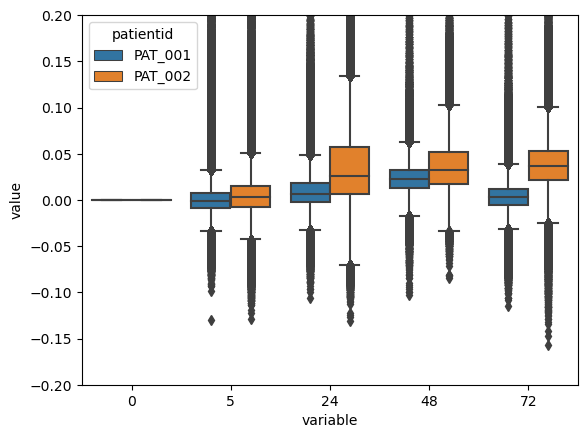

In [80]:
group = "white-matter"
patients = {
    "PAT_001": Path("DATA/PAT_001"),
    "PAT_002": Path("DATA/PAT_002")
}
seg_groups = default_segmentation_groups()

df = pd.concat(
    [patient_group_value(pat, patdir, group) for pat, patdir in patients.items()],
    ignore_index=True,
)
melted = pd.melt(df, id_vars=['patientid'])
seaborn.boxplot(melted, x='variable', y='value', hue='patientid')


<AxesSubplot: xlabel='hours', ylabel='median_concentration'>

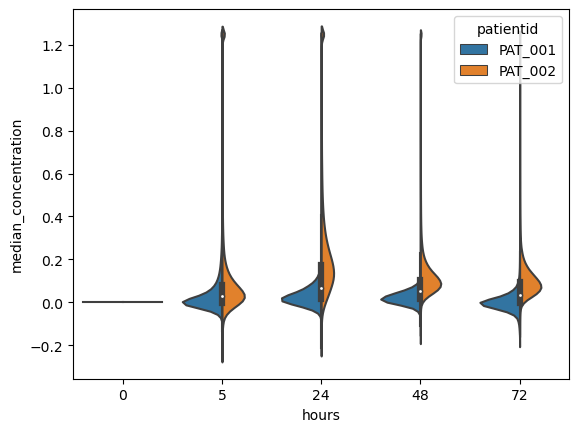

In [94]:
seaborn.violinplot(melted, x='hours', y='median_concentration', hue='patientid', split="true")

In [59]:
import seaborn

(-0.1, 0.2)

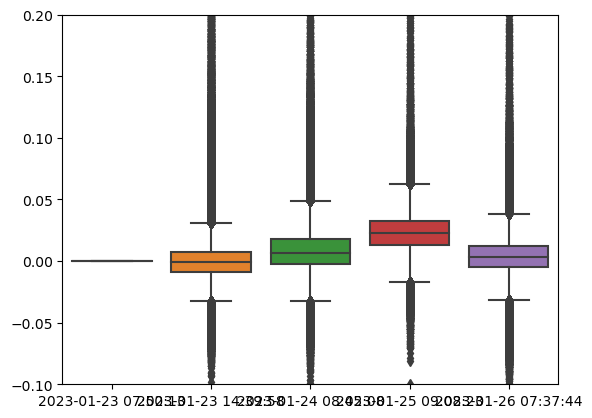

In [112]:
seaborn.boxplot(df[mask].drop(["aseg"], axis=1))
plt.ylim(-0.1, 0.2)

In [100]:
stat.T.swaplevel().loc["median"]["wm-cerebral"]

2023-01-23 07:50:13    0.000000
2023-01-23 14:39:58   -0.001111
2023-01-24 08:45:08    0.006624
2023-01-25 09:08:23    0.022467
2023-01-26 07:37:44    0.003578
Name: wm-cerebral, dtype: float64

<AxesSubplot: >

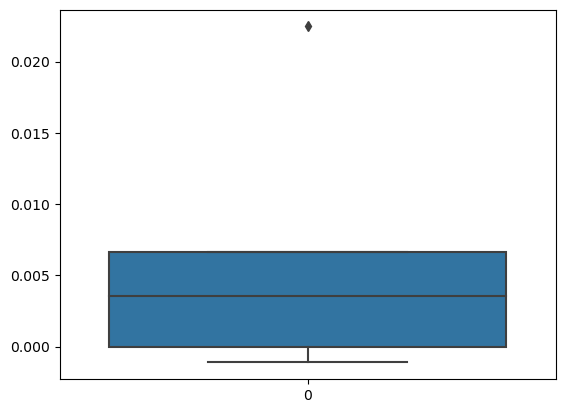

In [101]:
seaborn.boxplot(stat.T.swaplevel().loc["median"]["wm-cerebral"])

In [92]:
seg_groups = default_segmentation_groups()
print("+++ Segmentation Groups +++")
pprint.pprint(seg_groups)
print("\n"*3)


stat = df.dropna().groupby(["aseg"]).agg(aggregations)
for group, aseg_idx in seg_groups.items():
    mask = df["aseg"].isin(seg_groups[group])
    df_group  = df[mask].drop("aseg", axis=1)
    if df_group.size> 0:
        gr_stats = df_group.agg(aggregations)
        stat.loc[group] = flatten_dataframe(gr_stats)
stat.to_csv(statsdir / "statistics.csv", index=False)
return stat

+++ Segmentation Groups +++
{'cerebellum': [7, 8, 46, 47],
 'corpus-callosum': [251, 252, 253, 254, 255],
 'cortex-cerebellar': [8, 47],
 'cortex-cerebral': [3, 42],
 'csf': [4, 5, 14, 15, 24, 43, 44],
 'gray-matter': [3, 42, 8, 47],
 'white-matter': [2, 41, 7, 46, 77, 78, 70, 77, 78, 79, 80, 100, 109],
 'wm-cerebellar': [7, 46],
 'wm-cerebral': [2, 41],
 'wm-hypointensities': [77, 78, 70],
 'wm-pathological': [77, 78, 79, 80, 100, 109]}






SyntaxError: 'return' outside function (1544014411.py, line 15)

In [82]:
stat

2023-01-23 07:50:13                      \
                                median mean  std  p10  p90   
aseg                                                         
0                                  0.0  0.0  0.0  0.0  0.0   
2                                  0.0  0.0  0.0  0.0  0.0   
3                                  0.0  0.0  0.0  0.0  0.0   
7                                  0.0  0.0  0.0  0.0  0.0   
8                                  0.0  0.0  0.0  0.0  0.0   
10                                 0.0  0.0  0.0  0.0  0.0   
11                                 0.0  0.0  0.0  0.0  0.0   
12                                 0.0  0.0  0.0  0.0  0.0   
13                                 0.0  0.0  0.0  0.0  0.0   
16                                 0.0  0.0  0.0  0.0  0.0   
17                                 0.0  0.0  0.0  0.0  0.0   
18                                 0.0  0.0  0.0  0.0  0.0   
26                                 0.0  0.0  0.0  0.0  0.0   
28                                 0.0  0.0  0.0  0.0  0.0   
30                                 0.0  0.0  0.0  0.0  0.0   
31                                 0.0  0.0  0.0  0.0  0.0   
41                                 0.0  0.0  0.0  0.0  0.0   
42                                 0.0  0.0  0.0  0.0  0.0   
46                                 0.0  0.0  0.0  0.0  0.0   
47                                 0.0  0.0  0.0  0.0  0.0   
49                                 0.0  0.0  0.0  0.0  0.0   
50                                 0.0  0.0  0.0  0.0  0.0   
51                                 0.0  0.0  0.0  0.0  0.0   
52                                 0.0  0.0  0.0  0.0  0.0   
53                                 0.0  0.0  0.0  0.0  0.0   
54                                 0.0  0.0  0.0  0.0  0.0   
58                                 0.0  0.0  0.0  0.0  0.0   
60                                 0.0  0.0  0.0  0.0  0.0   
62                                 0.0  0.0  0.0  0.0  0.0   
63                                 0.0  0.0  0.0  0.0  0.0   
77                                 0.0  0.0  0.0  0.0  0.0   
85                                 0.0  0.0  0.0  0.0  0.0   
251                                0.0  0.0  0.0  0.0  0.0   
252                                0.0  0.0  0.0  0.0  0.0   
253                                0.0  0.0  0.0  0.0  0.0   
254                                0.0  0.0  0.0  0.0  0.0   
255                                0.0  0.0  0.0  0.0  0.0   
wm-cerebral                        0.0  0.0  0.0  0.0  0.0   
wm-cerebellar                      0.0  0.0  0.0  0.0  0.0   
wm-hypointensities                 0.0  0.0  0.0  0.0  0.0   
wm-pathological                    0.0  0.0  0.0  0.0  0.0   
cortex-cerebral                    0.0  0.0  0.0  0.0  0.0   
cortex-cerebellar                  0.0  0.0  0.0  0.0  0.0   
cerebellum                         0.0  0.0  0.0  0.0  0.0   
corpus-callosum                    0.0  0.0  0.0  0.0  0.0   
white-matter                       0.0  0.0  0.0  0.0  0.0   
gray-matter                        0.0  0.0  0.0  0.0  0.0   

                   2023-01-23 14:39:58                                \
                                median      mean       std       p10   
aseg                                                                   
0                             0.004957  0.084960  0.248268 -0.053083   
2                             0.000698  0.003401  0.039151 -0.017144   
3                             0.011861  0.032427  0.090952 -0.028753   
7                             0.003506  0.014537  0.083297 -0.017539   
8                             0.037395  0.120248  0.258519 -0.022544   
10                            0.009672  0.037690  0.105529 -0.007197   
11                            0.040351  0.076183  0.110241 -0.000769   
12                            0.001779  0.002971  0.015843 -0.015737   
13                            0.002953  0.003148  0.011166 -0.010379   
16                            0.013769  0.057657  0.15

In [90]:
import seaborn

In [91]:
group = "gray-matter"
pat1_median = stat.loc[group].swaplevel()["median"]

In [83]:
seaborn.boxplot(data=stat, x=""hue="patient")
plt.gca().set_ylim(0, 0.2)

ValueError: Cannot use `hue` without `x` and `y`

In [30]:
wm_median = wm_stats.T["median"]

In [31]:
wm_median.index = pd.to_datetime(wm_median.index)

In [32]:
wm_median

2023-01-23 07:50:13    0.000000
2023-01-23 14:39:58    0.001739
2023-01-24 08:45:08    0.006588
2023-01-25 09:08:23    0.019024
2023-01-26 07:37:44   -0.001538
Name: median, dtype: float64

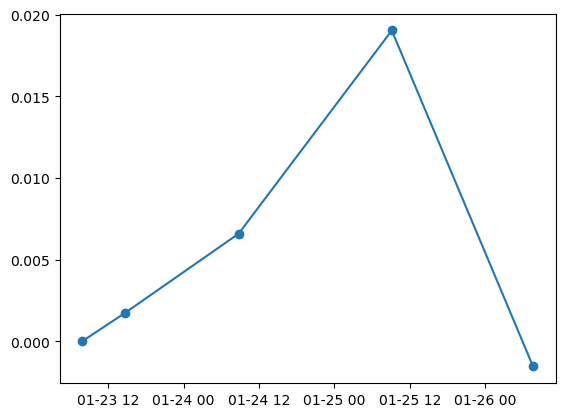

In [33]:
plt.plot(wm_median, "o-")

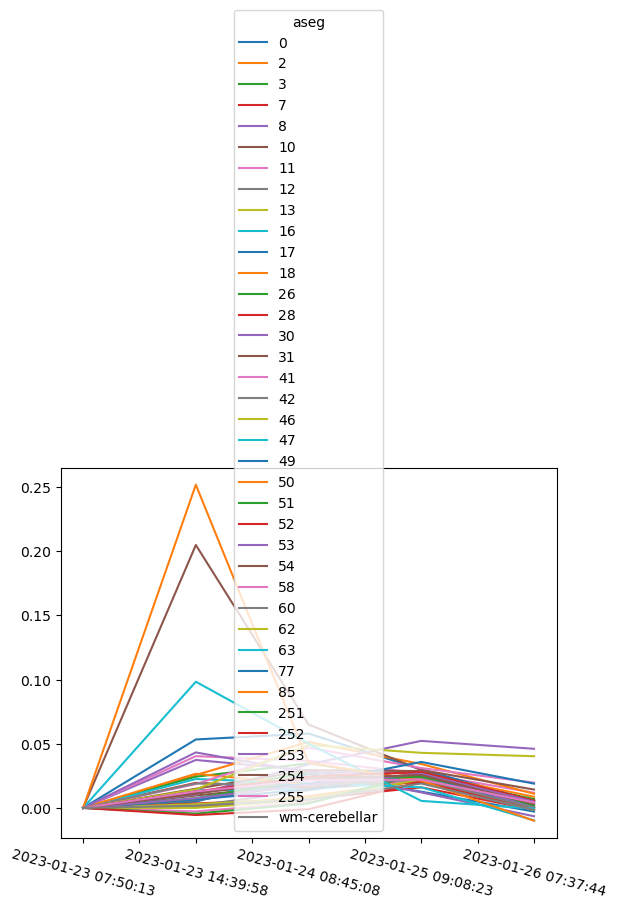

In [34]:
stat.T.swaplevel().loc["median"].plot(legend=True)
plt.xticks(rotation=-15)
# plt.ylim((None, 0.05))
plt.show()